In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import pandas as pd
import tensorflow as tf
import numpy as np
from glob import glob

2024-02-18 08:22:36.982412: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-18 08:22:37.213270: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-18 08:22:37.213308: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-18 08:22:37.253772: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-18 08:22:37.334539: I tensorflow/core/platform/cpu_feature_guar

In [3]:
df_nonflag = []
df_flag =[]
df_nonflag = pd.concat(
    [pd.read_parquet(x) for x in glob('./dataset/chats_nonflag_*.parquet')],
    ignore_index=True)
df_flag = pd.concat(
    [pd.read_parquet(x) for x in glob('./dataset/chats_flagged_*.parquet')],
    ignore_index=True)

df = pd.concat([df_nonflag, df_flag])

<Axes: ylabel='label'>

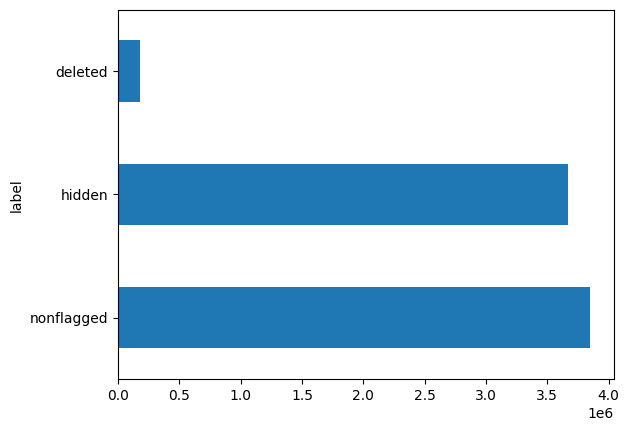

In [4]:
df['label'].value_counts().plot(kind='barh')

## Remove Duplicate Data

In [5]:
## Remove duplicate
print("Total data : ", len(df))
print("Total data after duplicates removes : ", len(df.drop_duplicates()))

Total data :  7700072
Total data after duplicates removes :  3618758


<Axes: ylabel='label'>

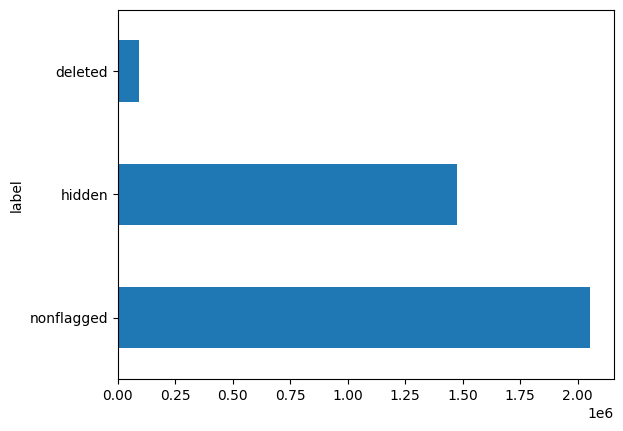

In [6]:
df = df.drop_duplicates()
df['label'].value_counts().plot(kind='barh')

In [7]:
df_labeled = df
df_labeled["label"] = np.where(df["label"].str.contains("nonflagged"), 0, 1)
df_labeled = df_labeled.sample(frac=1).reset_index(drop=True)
df_labeled.head(5)
#Flag = 1
#Nonflag = 0

,body,label
0,そうなんですか♫♫,0
1,古い…,0
2,gabisa donate hihihihi,1
3,宗谷さんのマブじゃん,0
4,witch part grow?,0


## Hyperparameter

In [8]:
#Hyperparam
vocab_size = 200000
embedding_dim = 16
max_length = 15
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

#Removing stopwords
import nltk.corpus
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/henriquesabino/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
import re

Words = []
Labels = []
for item in df_labeled.body :
  #item = re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", item)
  item = " ".join([word for word in item.split() if word not in (stop)])
  Words.append(item)

for item in df_labeled.label :
  Labels.append(item)

In [10]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler()
Words = np.array(Words)
Words_reshape = Words.reshape(-1, 1)
X_rus, y_rus= rus.fit_resample(Words_reshape, Labels)

from sklearn.model_selection import train_test_split
training_sentences, testing_sentences, training_labels, testing_labels = train_test_split(X_rus, y_rus, test_size=0.15, random_state=42)

training_sentences = training_sentences.tolist()
testing_sentences = testing_sentences.tolist()

training_sentences = [val for sublist in training_sentences for val in sublist]
testing_sentences = [val for sublist in testing_sentences for val in sublist]

In [11]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

## Create Model

In [12]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

2024-02-18 08:23:47.225879: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-18 08:23:47.352181: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-18 08:23:47.352240: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-18 08:23:47.353918: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-18 08:23:47.353962: I external/local_xla/xla/stream_executor

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 15, 16)            3200000   
                                                                 
 bidirectional (Bidirection  (None, 512)               559104    
 al)                                                             
                                                                 
 dense (Dense)               (None, 128)               65664     
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 512)               131584    
                                                                 
 dense_3 (Dense)             (None, 512)               262656    
                                                        

In [13]:
num_epochs = 200
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=1,batch_size=200)

Epoch 1/100


2024-02-18 08:23:51.090083: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-02-18 08:23:51.565026: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fab9dafc350 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-18 08:23:51.565070: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-02-18 08:23:51.575348: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1708255431.661600     965 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


13294/13294 [==============================] - ETA: 0s - loss: 0.6187 - accuracy: 0.6566

In [ ]:
model.save('./model/model.keras')

NameError: name 'model' is not defined

Text(0.5, 0, 'Época')

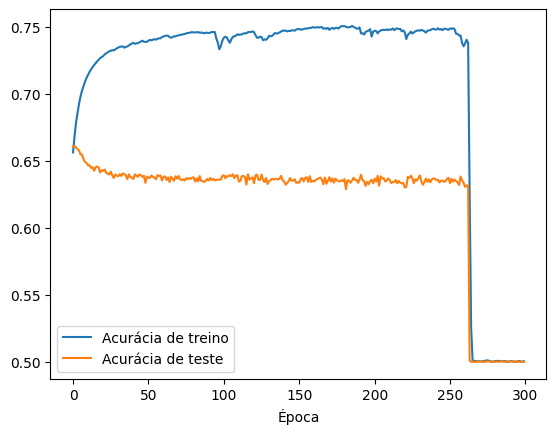

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.legend(["Acurácia de treino", "Acurácia de teste"])
plt.xlabel("Época")

Text(0.5, 0, 'Época')

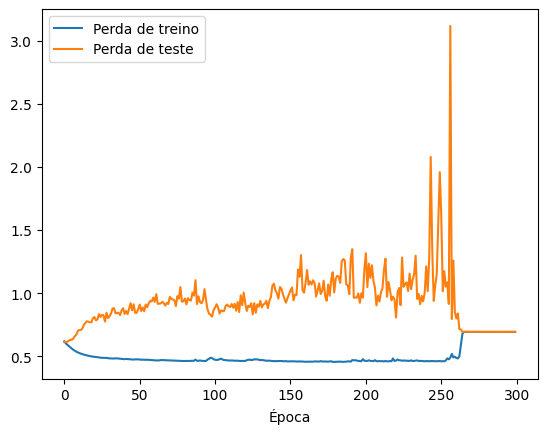

In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(["Perda de treino", "Perda de teste"])
plt.xlabel("Época")

In [ ]:
padded_test_phrase = pad_sequences(tokenizer.texts_to_sequences(["good night calli. i was lurking rest of it"]))
print(padded_test_phrase)
model.predict(padded_test_phrase)

[[   9  209  125    2  525 6096  449  257   23]]
1/1 [==============================] - 0s 24ms/step


array([[0.5043489]], dtype=float32)